# Malicous Domain Dataset Preprocessing

In [588]:
import pandas as pd

datasource = "dataset.csv"
data = pd.read_csv(datasource)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Domain               90000 non-null  int64  
 1   DNSRecordType        90000 non-null  object 
 2   MXDnsResponse        90000 non-null  bool   
 3   TXTDnsResponse       90000 non-null  bool   
 4   HasSPFInfo           90000 non-null  bool   
 5   HasDkimInfo          90000 non-null  bool   
 6   HasDmarcInfo         90000 non-null  bool   
 7   Ip                   90000 non-null  int64  
 8   DomainInAlexaDB      90000 non-null  bool   
 9   CommonPorts          90000 non-null  bool   
 10  CountryCode          60948 non-null  object 
 11  RegisteredCountry    12226 non-null  object 
 12  CreationDate         90000 non-null  int64  
 13  LastUpdateDate       90000 non-null  int64  
 14  ASN                  90000 non-null  int64  
 15  HttpResponseCode     90000 non-null 

In [589]:
data.describe()

,Domain,Ip,CreationDate,LastUpdateDate,ASN,HttpResponseCode,SubdomainNumber,Entropy,EntropyOfSubDomains,StrangeCharacters,ConsoantRatio,NumericRatio,SpecialCharRatio,VowelRatio,ConsoantSequence,VowelSequence,NumericSequence,SpecialCharSequence,DomainLength,Class
count,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,44999.500000,13479.648033,1.933611,2.365744,23335.808167,0.667033,103.069200,2.866844,0.003178,3.498011,0.459519,0.144281,0.006526,0.261528,2.719222,1.342756,1.516478,0.112378,26.440422,0.500000
std,25980.906451,4160.266410,1.997232,1.935509,37004.865724,1.203285,4243.802846,0.488291,0.081042,4.471591,0.146031,0.147331,0.026162,0.098600,1.699339,0.554527,1.538932,0.431967,22.341135,0.500003
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
25%,22499.750000,11709.750000,0.000000,0.000000,-1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.200000,2.000000,1.000000,0.000000,0.000000,15.000000,0.000000
50%,44999.500000,14626.000000,0.000000,4.000000,26228.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.500000,0.100000,0.000000,0.200000,2.000000,1.000000,1.000000,0.000000,24.000000,0.500000
75%,67499.250000,16984.000000,4.000000,4.000000,26228.000000,2.000000,57.000000,3.000000,0.000000,7.000000,0.600000,0.300000,0.000000,0.300000,3.000000,2.000000,3.000000,0.000000,31.000000,1.000000
max,89999.000000,16984.000000,4.000000,4.000000,398108.000000,5.000000,661909.000000,5.000000,3.000000,124.000000,1.000000,0.800000,0.900000,0.800000,37.000000,7.000000,45.000000,61.000000,153.000000,1.000000


## Feature Processing

### Domain

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | N/A           |

The anonymized domain name. Anonymized by mapping a unique domain name to a unique integer (ie `google.com -> 1`).

In [590]:
# Are there any duplicate rows?
print("Duplicate values: %d" % (data["Domain"].size - data["Domain"].unique().size))

# Are there any null values?
print("Null values: %d" % (data["Domain"].isnull().sum()))

Duplicate values: 0
Null values: 0


The domain feature is the base feature of this dataset. That is, all other features are derived from the domain name. Thus we do not want to use this feature in a model and we remove it from the dataset.

In [591]:
data = data.drop(columns=["Domain"])

### DNSRecordType

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | N/A           |

The DNS record type. Types are one of the following:

|  Type   | Description |
| :-----: | :---------: |
| A       | IPv4 Record |
| AAAA    | IPv6 Record |
| CNAME   | Canonical Name Record |
| MX      | Mail Exchange Record  |

In [592]:
# Get class breakdown of domains based on this feature
data.groupby(["DNSRecordType", "Class"]).agg({"Class": "count"})

Class
DNSRecordType Class       
A             0      45000
              1       4529
CNAME         1      35997
MX            1       4474

The dataset does not have a good mix of records -> classes. Both CNAME and MX have zero non malicious data points. Further, if we check for duplicates now that we have removed the base feature we see that datapoints with the record type CNAME suffer from a large volume of duplicate data:

In [593]:
data[data.DNSRecordType == "CNAME"].drop_duplicates()["Class"].value_counts()

1    1981
Name: Class, dtype: int64

Above we see the removing the duplicates from the CNAME type datapoints reduces the number of points from 35,997 to 1,981.

Without access to the deanonymized dataset and without knowing the exact procedure that was utilized to produce this data we will not speculate on the cause of this duplicate data, but it indicates that the CNAME type datapoints are unsuitable for use in model construction.

In [594]:
data[data.DNSRecordType == "A"].drop_duplicates()["Class"].value_counts()

0    33184
1     4102
Name: Class, dtype: int64

As seen above duplicate data is far less prevalent in the set of type A records. Thus we will restrict the data used for model training and validation to a subset of the type A records.

In [595]:
# Drop all datapoints that are not type A
data = data[data.DNSRecordType == "A"]

# Drop duplicate rows
data = data.drop_duplicates()

In [596]:
# Get class breakdown of domains based on this feature
data.groupby(["DNSRecordType", "Class"]).agg({"Class": "count"})

Class
DNSRecordType Class       
A             0      33184
              1       4102

Note that by removing all but type A datapoints the dataset has become imbalanced. This will be taken into account by using stratified sampling during model training and cross validation.

Finally, we drop the DNSRecordType feature as it is no longer relevant.

In [597]:
data = data.drop(columns=["DNSRecordType"])

### MXDnsResponse

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

Whether or not a request for MX info returns information.

In [598]:
# Get class breakdown of domains based on this feature
data.groupby(["MXDnsResponse", "Class"]).agg({"Class": "count"})

Class
MXDnsResponse Class       
False         0      18798
              1       3352
True          0      14386
              1        750

### TXTDnsResponse

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

Whether or not a request for TXT info returns information.

In [599]:
# Get class breakdown of domains based on this feature
data.groupby(["TXTDnsResponse", "Class"]).agg({"Class": "count"})

Class
TXTDnsResponse Class       
False          0      22791
               1       3410
True           0      10393
               1        692

### HasSPFInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Sender Policy Framework (SPF) attribute. SPF records list the servers authorized to send messages on behalf of a domain and are used to combat email spoofing.

In [600]:
# Get class breakdown of domains based on this feature
data.groupby(["HasSPFInfo", "Class"]).agg({"Class": "count"})

Class
HasSPFInfo Class       
False      0      23585
           1       3692
True       0       9599
           1        410

### HasDkimInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Domain Keys Identified Mail (DKIM) attribute. DKIM records store the public key used to verify the authenticity of emails and are used to help prevent domian spoofing.

In [601]:
# Get class breakdown of domains based on this feature
data.groupby(["HasDkimInfo", "Class"]).agg({"Class": "count"})

Class
HasDkimInfo Class       
False       0      33165
            1       4101
True        0         19
            1          1

As such a small quantity of domains in the dataset have DKIM information we will remove the feature.

In [602]:
data = data.drop(columns=["HasDkimInfo"])

### HasDmarcInfo

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the DNS record has the Domain-based Message Authentication and Conformance (DMARC) attribute. DMARC records specify policy for what happens to emails after they pass or fail SPF and DKIM checks.

In [603]:
# Get class breakdown of domains based on this feature
data.groupby(["HasDmarcInfo", "Class"]).agg({"Class": "count"})

Class
HasDmarcInfo Class       
False        0      31949
             1       3901
True         0       1235
             1        201

### IP

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | null          |

The anonymized internet protocol (IP) address associated with the domain. This feature is irrelevant to the model so it will be removed.

In [604]:
data = data.drop(columns=["Ip"])

### DomainInAlexaDB

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the domain is registered in the Alexa top sites database.

In [605]:
# Get class breakdown of domains based on this feature
data.groupby(["DomainInAlexaDB", "Class"]).agg({"Class": "count"})

Class
DomainInAlexaDB Class       
False           0      31744
                1       3737
True            0       1440
                1        365

### CommonPorts

|  Type   | Default Value |
| :-----: | :-----------: |
| Boolean | False         |

If the domain has an available service on any of the following common ports: 80, 443, 21, 22, 23, 25, 53, 110, 143, 161, 445, 465, 587, 993, 995, 3306, 3389, 7547, 8080, 8888.

In [606]:
# Get class breakdown of domains based on this feature
data.groupby(["CommonPorts", "Class"]).agg({"Class": "count"})

Class
CommonPorts Class       
False       0      25189
            1       3721
True        0       7995
            1        381

### CountryCode

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | null         |

The country code associated with the domain's IP address. The publishers of this dataset suggest that the country code data is likely skewed by sinkhole DNS servers which point known bad domains to known safe addresses. Thus this data will be discarded.

<AxesSubplot:title={'center':'Top 10 IP Country Codes'}>

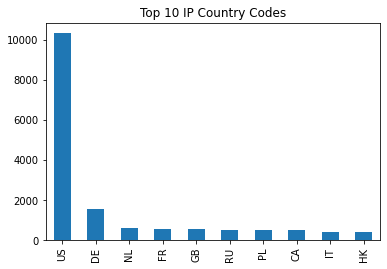

In [607]:
# Plot a barchart displaying the domain counts for the top ten countries
data.CountryCode.value_counts().head(10).plot.bar(title="Top 10 IP Country Codes")

In [608]:
data = data.drop(columns=["CountryCode"])

### RegisteredCountry

|  Type   | Default Value |
| :-----: | :-----------: |
| Text    | null          |

The country code associated with the domain's registration information.

<AxesSubplot:title={'center':'Top 10 Registration Country Codes'}>

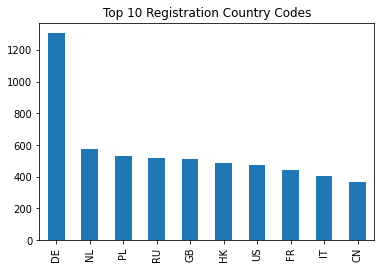

In [609]:
# Plot a barchart displaying the domain counts for the top ten countries
data.RegisteredCountry.value_counts().head(10).plot.bar(title="Top 10 Registration Country Codes")

Note how this distribution significantly differs from the IP based country code data. This is likely due to the fact that unlike CountryCode, RegisteredCountry is not dependent on the IP lookup that was causing skewed results.

In [610]:
# Get class breakdown of domains based on this feature
data.groupby(["RegisteredCountry", "Class"]).agg({"Class": "count"})

Class
RegisteredCountry Class       
AE                0          5
AL                1          1
AT                0         34
AU                0        297
                  1          2
...                        ...
md                0          1
ro                0         11
ru                0          2
ua                0          1
vn                0          6

[139 rows x 1 columns]

In [611]:
# Are there any null values?
print("Null values: %d" % (data["RegisteredCountry"].isnull().sum()))

Null values: 27803


Discarding this feature due to the large volume of null values and the small sample sizes for many countries.

In [612]:
data = data.drop(columns=["RegisteredCountry"])

### CreationDate

|  Type   | Default Value |
| :-----: | :-----------: |
| Enum    | null          |

The age of the domain enumerated into the following bins:

| Enum | Date      |
| :--: | :-------: |
| 0    | No Data   |
| 1    | < 1 month |
| 2    | < 6 months |
| 2    | < 1 year |
| 2    | >= 1 year |

In [613]:
# Get class breakdown of domains based on this feature
data.groupby(["CreationDate", "Class"]).agg({"Class": "count"})

Class
CreationDate Class       
0            0      22269
             1       3449
1            0         11
2            0         45
             1          1
3            0         97
             1          5
4            0      10762
             1        647

### LastUpdateDate

|  Type   | Default Value |
| :-----: | :-----------: |
| Enum    | null          |

The time since the reigstration information was last updated enumerated into the following bins:

| Enum | Date      |
| :--: | :-------: |
| 0    | No Data   |
| 1    | < 1 month |
| 2    | < 6 months |
| 2    | < 1 year |
| 2    | >= 1 year |

In [614]:
# Get class breakdown of domains based on this feature
data.groupby(["LastUpdateDate", "Class"]).agg({"Class": "count"})

Class
LastUpdateDate Class       
0              0      14355
               1       3017
1              0        212
               1         26
2              0       1111
               1         47
3              0        951
               1         43
4              0      16555
               1        969

### ASN

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | -1            |

The Autonomous System Number (ASN) associated with the domain's IP address. Discarding for simillar reasons to the country code feature and the large volume of missing values.

<AxesSubplot:title={'center':'Top 10 ASNs'}>

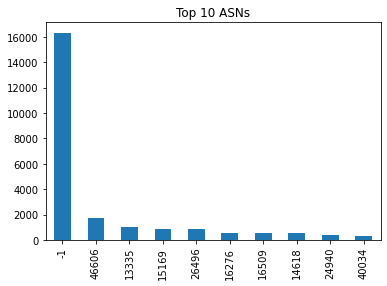

In [615]:
# Plot a barchart displaying the domain counts for the top ten ASNs
data.ASN.value_counts().head(10).plot.bar(title="Top 10 ASNs")

In [616]:
data = data.drop(columns=["ASN"])

### HttpResponseCode

|  Type   | Default Value |
| :-----: | :-----------: |
| Enum    | 0             |

The HTTP response code returned from querying the domain via HTTP(S). 

| Enum | Status |
| :--: | :----: |
| 0    | No data     |
| 1    | 1XX (Info)  |
| 2    | 2XX (Success) |
| 3    | 3XX (Redirect)|
| 4    | 4XX (Client error) |
| 5    | 5XX (Server error) |


In [617]:
# Get class breakdown of domains based on this feature
data.groupby(["HttpResponseCode", "Class"]).agg({"Class": "count"})

Class
HttpResponseCode Class       
0                0      16395
                 1       3622
2                0      12669
                 1        336
4                0       3773
                 1        108
5                0        347
                 1         36

### RegisteredOrg

Original
|  Type | Default Value |
| :---: | :-----------: |
| Text  | null          |

The organization name associated with the domain registration information.

Transformed
|  Type    | Default Value |
| :------: | :-----------: |
| Boolean  | N/A           |

Whether or not the domain has an organization associated with it in its registration information.

<AxesSubplot:title={'center':'Top 10 Orgs'}>

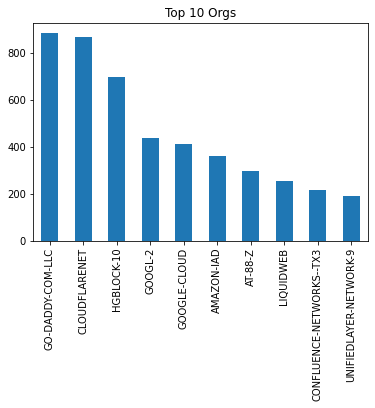

In [618]:
# Plot a barchart displaying the domain counts for the top ten Orgs
data.RegisteredOrg.value_counts().head(10).plot.bar(title="Top 10 Orgs")

In [619]:
# Are there any null values?
print("Null values: %d" % (data["RegisteredOrg"].isnull().sum()))

Null values: 17342


<AxesSubplot:title={'center':'Class of Null RegisteredOrg Values'}>

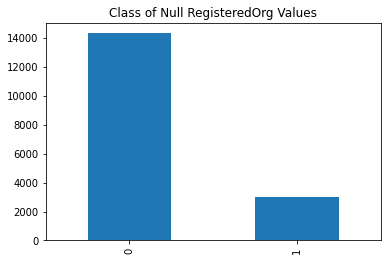

In [620]:
data["Class"][data.RegisteredOrg.isnull()].value_counts().plot.bar(title="Class of Null RegisteredOrg Values")

As seen above, there is a significant number of null values for this feature. And a large majority of datapoints with a null RegisteredOrg are classified as malicious. The publishers of this dataset state that this is likely due to malicous actors being less likely to release this information.

Given the above information, we will transform this feature from the text datatype to a boolean datatype which represents whether or not the registered organization was available for a given domain.

In [621]:
data["RegisteredOrg"] = ~data.RegisteredOrg.isnull()

### SubdomainNumber

|  Type   | Default Value |
| :-----: | :-----------: |
| Integer | 0             |

The number of subdomains the domain has. 

In [632]:
# Get class breakdown of domains based on this feature
(data.groupby(["SubdomainNumber", "Class"]).agg({"Class": "count"})).head(21)

Class
SubdomainNumber Class       
0               0      31231
                1       3834
1               0        731
                1         21
2               0        206
                1         17
3               0        164
                1          1
4               0         56
                1          3
5               0         49
                1          1
6               0         56
                1          5
7               0         18
                1          1
8               0         17
                1          1
9               0         11
                1          2
10              0        106

<AxesSubplot:>

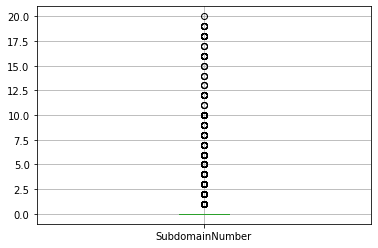

In [635]:
data.boxplot(column="SubdomainNumber")

In [579]:
data.SubdomainNumber.describe()

count     37286.000000
mean        186.579789
std        6545.915668
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      661909.000000
Name: SubdomainNumber, dtype: float64

This attribute appears to have a significant outlier problem.

In [585]:
Subdomain_Q1 = data["SubdomainNumber"].quantile(0.25)
Subdomain_Q3 = data["SubdomainNumber"].quantile(0.75)
Subdomain_IQR = Subdomain_Q3 - Subdomain_Q1
Subdomain_LowerLim = Subdomain_Q1 - 1.5 * Subdomain_IQR
Subdomain_UpperLim = Subdomain_Q3 + 1.5 * Subdomain_IQR
print("Subdomain Outlier Lower Limit: ", Subdomain_LowerLim)
print("Subdomain Outlier Upper Limit: ", Subdomain_UpperLim)

Subdomain Outlier Lower Limit:  0.0
Subdomain Outlier Upper Limit:  0.0


As the lower and upper limit are both 0 and we know not all non zero values are outliers IQR is not an effective method of handling outliers here. Instead we discard any rows with SubdomainNumber > 20.

In [634]:
data["SubdomainNumber"] = data["SubdomainNumber"][~(data["SubdomainNumber"] > 20)]
data.SubdomainNumber.describe()

count    36592.000000
mean         0.135084
std          0.987159
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: SubdomainNumber, dtype: float64

<AxesSubplot:xlabel='SubdomainNumber'>

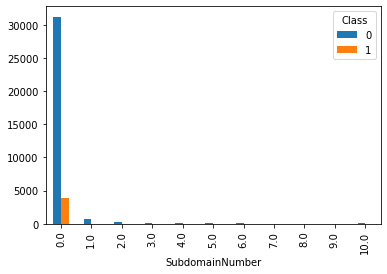

In [637]:
pd.crosstab(data["SubdomainNumber"], data["Class"]).head(11).plot.bar()

<AxesSubplot:xlabel='SubdomainNumber'>

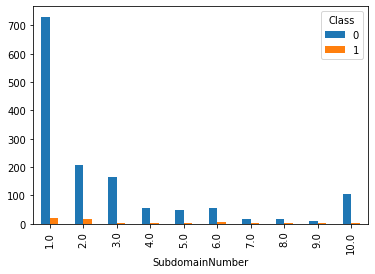

In [638]:
pd.crosstab(data["SubdomainNumber"], data["Class"]).head(11).tail(10).plot.bar()